# Titanic dataset - Decision Trees

In [1]:
# Imports
import os
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read data
data_path = "C:\\data\\kaggle\\titanic"
df_test = pd.read_csv(data_path+'\\test.csv', engine='python')
df_original = pd.read_csv(data_path+'\\train.csv', engine='python')
df_output_example = pd.read_csv(data_path+'\\gender_submission.csv', engine='python')

In [3]:
df_original.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


To do:

- Estimate ages?

- Separate sib/sp and par/ch?

- Separate surnames?


In [4]:
def get_metrics(cm, to_print=False):
    TP = cm[0][0]
    TN = cm[1][1]
    FP = cm[1][0]
    FN = cm[0][1]
    accuracy = ((TP+TN)/(TP+FP+FN+TN))
    precision = (TP/(TP+FP))
    recall = (TP/(TP+FN))
    f1score = (2/((1/recall)+(1/precision)))
    
    if to_print:    
        print('Accuracy:', accuracy, '\nPrecision:', precision, '\nRecall:', recall, '\nF1 score:', f1score)
        
    return accuracy, precision, recall, f1score

## First attempt (out of the box)
Dropping original indexes

Results: [120,  37],
              [ 49,  61]

In [15]:
df = df_original.copy()

## EMBARKED
# Southampton Cherbourg Queenstown to 0, 1, 2
df.Embarked = [0 if city == 'S' else 1 if city == 'C' else 2 for city in df_original.Embarked]


## SEX
# Sex to bool
df['Female'] = [0 if sex == 'Male' else 1 for sex in df.Sex]
df = df.drop(columns=['Sex'])


## CABIN
# TEMP Cabin to type
le_cabintypes = LabelEncoder()
le_cabintypes.fit(df_original.Cabin.astype(str).str[0].unique())
df['CabinType'] = le_cabintypes.transform(df_original.Cabin.astype(str).str[0])
df = df.drop(columns=['Cabin'])


# NAMES
le_titles = LabelEncoder()
le_titles.fit(list(set([name.split(', ')[1].split('.')[0] for name in df_original.Name])))
df['Title'] = le_titles.transform([name.split(', ')[1].split('.')[0] for name in df_original.Name])
df = df.drop(columns=['Name'])


# Temp drop columns
df = df.drop(columns=['Ticket'])

# TEMP Fill NaN with 0
df = df.fillna(0)

df = df.set_index('PassengerId', drop=True)

In [6]:
# Randomly break into 70% train and 30% cross-validation

# Training set
train = df.sample(frac=0.7, axis=0) #.reset_index(drop=True)
train_x = train.drop(columns='Survived').copy()
train_y = train.loc[:][['Survived']]

# Cross-validation set
cross = df.drop(train.index)
cross_x = cross.drop(columns='Survived').copy()
cross_y = cross.loc[:][['Survived']]

In [7]:
# Fit classification model
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_x, train_y)

In [8]:
# Predict
pred_y = clf.predict_proba(cross_x)

[[139  25]
 [ 32  71]]


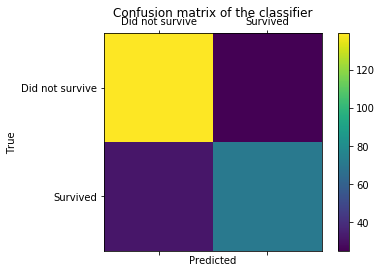

Accuracy: 0.7865168539325843 
Precision: 0.8128654970760234 
Recall: 0.8475609756097561 
F1 score: 0.8298507462686566


(0.7865168539325843,
 0.8128654970760234,
 0.8475609756097561,
 0.8298507462686566)

In [9]:
# Confusion Matrix
pred_y2 = np.argmax(pred_y, axis=1)

labels = ['Did not survive', 'Survived']
cm = sklearn.metrics.confusion_matrix(cross_y, pred_y2)

# Plotting
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

get_metrics(cm, True)

## Past results:

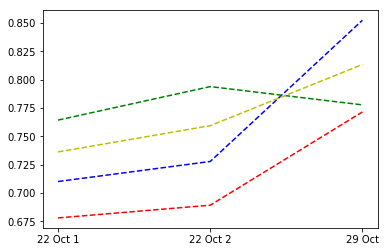

In [32]:
# Past results
data = {'22 Oct 1': [[120, 37], [ 49, 61]],
        '22 Oct 2': [[131, 34], [ 49, 53]],
        '29 Oct'  : [[133, 38], [ 23, 73]]}
names = list(data.keys())
values = list(data.values())

accuracy = [] # ratio of correctly predicted observation to the total observations
precision = [] # ratio of correctly predicted positive observations to the total predicted positive observations
recall = [] # ratio of correctly predicted positive observations to the all observations in actual class - yes
f1score = [] # weighted average of Precision and Recall

for cm in values:
    TP = cm[0][0]
    TN = cm[1][1]
    FP = cm[1][0]
    FN = cm[0][1]
    accuracy.append((TP+TN)/(TP+FP+FN+TN))
    precision.append(TP/(TP+FP))
    recall.append(TP/(TP+FN))
    f1score.append(2/((1/recall[-1])+(1/precision[-1])))
    
#print('Accuracy:', accuracy, '\nPrecision:', precision, '\nRecall:', recall, '\nF1 score:', f1score)

# Plot curves TODO
plt.plot(names, accuracy, 'r--', names, precision, 'b--', names, recall, 'g--', names, f1score, 'y--')
plt.show()

In [11]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Female,CabinType,Title
PassengerId,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,0,1,8,11
2,1,1,38.0,1,0,71.2833,1,1,2,12
3,1,3,26.0,0,0,7.9250,0,1,8,8
4,1,1,35.0,1,0,53.1000,0,1,2,12
5,0,3,35.0,0,0,8.0500,0,1,8,11


In [16]:
df_original.Ticket

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
5                330877
6                 17463
7                349909
8                347742
9                237736
10              PP 9549
11               113783
12            A/5. 2151
13               347082
14               350406
15               248706
16               382652
17               244373
18               345763
19                 2649
20               239865
21               248698
22               330923
23               113788
24               349909
25               347077
26                 2631
27                19950
28               330959
29               349216
             ...       
861               28134
862               17466
863            CA. 2343
864              233866
865              236852
866       SC/PARIS 2149
867            PC 17590
868              345777
869              347742
870              349248
871             

In [29]:
[print(cm) for cm in values]

[[120, 37], [49, 61]]
[[131, 34], [49, 53]]
[[133, 38], [23, 73]]


[None, None, None]